In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
df=pd.read_csv('quality_label.csv')
second_col = df.iloc[:, 1]
conditions = [
    second_col.isin([1, 2, 3]),
    second_col == 4,
    second_col == 5
]

choices = [1, 2, 3]

label = np.select(conditions, choices, default=0).reshape(-1,1)  # optional default if none match

In [3]:
dataset=np.load('dataset_bin.npz')

feature_names = ['Kurosis(signal)', 'Energy ratio(Low)', 'Energy ratio(Mid)', 'Energy ratio(High)', 'Std(envelope)', 'Sample Entropy(envelope)', 'Kurosis(auto correlation)', 'Max Peak(auto correlation)', 'Sample Entropy(auto correlation)', 'Degree of periodicity']  # <- replace with your actual names
full_data = np.hstack((dataset['data'], label))
column_names = feature_names + ['label']

In [4]:
df = pd.DataFrame(full_data, columns=column_names)
df['label']=df['label'].astype('int')
df.to_pickle('dataset_tri.pkl')

In [5]:
X = df.drop(['label'], axis=1)
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 21)

In [7]:
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
pipeline = make_pipeline(StandardScaler(),svm.SVC())
param_distributions = {
    'svc__C': uniform(0.1, 100),       # Samples C between 0.1 and 100
    'svc__gamma': uniform(0.001, 1),   # Samples gamma between 0.001 and 1
    'svc__kernel': ['rbf'],
    'svc__class_weight':['balanced', None]
}

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,             # Try 50 different combinations
    scoring='accuracy',
    cv=5,
    random_state=70,
    verbose=4,
    n_jobs=-1
)
search.fit(X_train, y_train)
print("Best Params:", search.best_params_)
print("Best CV Score:", search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'svc__C': np.float64(30.806466166479996), 'svc__class_weight': None, 'svc__gamma': np.float64(0.11678370620105127), 'svc__kernel': 'rbf'}
Best CV Score: 0.8369708893756629


Accuracy: 0.8240506329113924


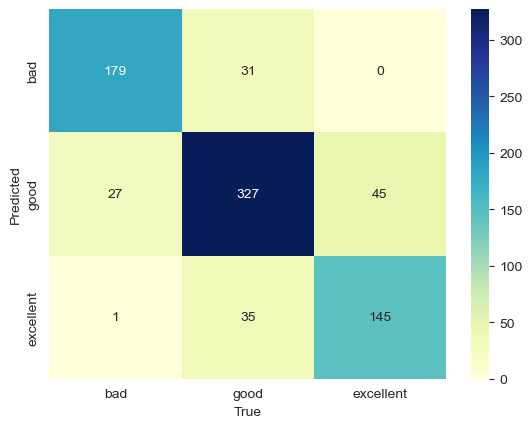

In [20]:
import matplotlib.pyplot as plt
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm,columns=['bad','good','excellent'],index=['bad','good','excellent'])
ax=sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_ylabel('Predicted')
ax.set_xlabel('True')
plt.savefig('confusion_matrix.png')
plt.show()